# Попробуем генерацию последовательностей на RNN
- это задача суммаизации, обычно решается seq2seq методами
- интересно, что даст просто RNN

## Импорты модулей

In [23]:
%load_ext autoreload    
%autoreload 2

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchtext.data.metrics import bleu_score

from transformers.utils import logging
from helpers.utils import count_parameters, epoch_time

import youtokentome as yttm

import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
logging.set_verbosity_error()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.deterministic = True   # avoid some rnn issues on some cuDNN versions

In [25]:
MODEL_NAME = 'models/lstm_bpe_baseline.pt'

# Датасеты

- жаль, что yttm не умеет сериализоваться

In [26]:
QUICK_RUN = False

DICT_SIZE = 300 if QUICK_RUN else 3000

TRAIN_FILE = f"{'./cache/' if QUICK_RUN else './datasets/'}train.csv"
FIN_TEST_FILE = f"{'./cache/' if QUICK_RUN else './datasets/'}test.csv"

In [27]:
class BPEncoder():
    def __init__(self, path_to_data, dict_size=1000):
        """YouTokenToMe - работает только через внешний файл"""
        
        self.eoa = "<eoa>"
        self.train_file = "./cache/input_file.txt"
        self.model_file = MODEL_NAME + ".yttm"
        self.dict_size = dict_size

        print("Reading data...")
        self.train_data = pd.read_csv(path_to_data)
        with open("./cache/input_file.txt", 'w') as f:
            f.writelines((self.train_data["abstract"] + self.eoa + self.train_data["title"] + "\n").to_list())

        if not os.path.isfile(self.model_file):
            print("Train tokenizer...")
            yttm.BPE.train(data=self.train_file, vocab_size=self.dict_size, model=self.model_file)

        self.tokenizer = yttm.BPE(self.model_file)
    
    def encode(self, texts):
        texts = [t.lower() for t in texts]
        encodings = self.tokenizer.encode(texts, output_type=yttm.OutputType.ID, bos=2, eos=3)
        length = list(map(len, encodings))
        return {"input_ids": encodings, "length": length}
    
    def tokenize(self, texts):
        return self.tokenizer.encode(texts, output_type=yttm.OutputType.SUBWORD, bos=2, eos=3)

    def padded_encode(self, texts, dtype='int32', batch_first = True):
        vectors = self.tokenizer.encode(texts, output_type=yttm.OutputType.ID, bos=2, eos=3)

        max_batch_len = max(map(len, vectors))
        data_ix = np.zeros([len(texts), max_batch_len], dtype)
        
        for i in range(len(texts)):
            data_ix[i, :len(vectors[i])] = vectors[i]
        
        if not batch_first:                                     # [batch, token] -> [token, batch] (не используется)
            data_ix = np.transpose(data_ix)

        return {"input_ids": data_ix}

    def decode(self, vectors, drop_special_tokens=True):
        return self.tokenizer.decode(vectors, 
                                     ignore_ids=[0,1,2,3] if drop_special_tokens else None)

bpe = BPEncoder(TRAIN_FILE, dict_size=DICT_SIZE)
bpe.tokenizer.id_to_subword(bpe.tokenizer.subword_to_id(bpe.eoa)), \
bpe.decode(bpe.encode(["Hello world!", "GNU is not Unix :((( #sometag"])["input_ids"])

Reading data...


('<eoa>', ['hello world!', 'gnu is not unix :((( #sometag'])

In [28]:
class ArXivBPE(Dataset):
    def __init__(self, path, tokenizer, drop_long=True):
        """Добавлен спец.токен для разделения аннотации и заголовка, 
        чтоб НС запоминала такие места:
        - предполагается, что также он будет добавлен к стартовой последовательности 
        при генерации
        - весь датасет кодируется без паддинга, чтоб добавить паддинг уже в батчи
        - не включаем длинные последовательности (больше 1200 символов, 75% квантиль)"""

        print("Reading data...")
        self.data = pd.read_csv(path)
        self.data.drop_duplicates(inplace=True, ignore_index=True)
        if drop_long:
            self.data = self.data[self.data.applymap(lambda x: len(str(x))).abstract < 1200].reset_index(drop=True)
        
        self.tokenizer = tokenizer
        self.sequences = self.data["abstract"] + self.tokenizer.eoa + self.data["title"]

        print("Encoding data...")
        self.encodings = self.tokenizer.encode(self.sequences.tolist())

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["sequence"] = self.sequences[idx]
        item["length"] = self.encodings["length"][idx]
        return item

    def __len__(self):
        return len(self.sequences)

    def split(self, split=0.7, split_ratio=None):
        """ Выделение тестовой/валидационной выборки
        - принимает либо долю тренировочной выборки, либо список долей любой длины
        - все делать руками, это и есть новый подход torchtext вместо legacy Dataset?"""
        size = len(self)
        split_ratio = split_ratio if split_ratio else [split, 1 - split]
        split_size = [int(r * size) for r in split_ratio]
        split_size[-1] = size - sum(split_size[:-1])
        return torch.utils.data.random_split(self, split_size)

In [29]:
all_train_dataset = ArXivBPE(TRAIN_FILE, tokenizer=bpe)  # Dataset

Reading data...
Encoding data...


- тренировочный, валидационный и тестовый датасеты (`Subset`)

In [30]:
train_dataset, val_dataset, test_dataset = all_train_dataset.split(split_ratio=[0.98, 0.01, 0.01])  # Subset

list(map(len, (train_dataset, val_dataset, test_dataset)))

[76783, 783, 785]

- данные для итогового скоринга

In [31]:
fin_test_src = pd.read_csv(FIN_TEST_FILE).abstract.to_list()    # итоговые тестовые резюме статей

- что получается

In [32]:
print(train_dataset[0])
bpe.decode(train_dataset[0]["input_ids"])

{'input_ids': [2, 81, 4, 46, 142, 251, 476, 46, 2254, 2446, 129, 75, 2301, 475, 133, 755, 502, 93, 75, 514, 93, 623, 296, 25, 750, 431, 149, 81, 235, 7, 454, 151, 465, 368, 153, 849, 183, 559, 97, 81, 623, 93, 81, 735, 262, 735, 766, 129, 75, 2301, 1483, 649, 235, 7, 454, 151, 465, 296, 25, 750, 184, 1380, 129, 819, 650, 362, 881, 262, 2135, 923, 2700, 732, 1996, 372, 296, 25, 750, 428, 1921, 117, 649, 1388, 164, 1957, 235, 7, 454, 151, 465, 2446, 162, 2412, 240, 1249, 887, 849, 445, 163, 2697, 183, 93, 1065, 129, 881, 262, 2135, 2446, 202, 240, 1249, 2805, 184, 1927, 129, 1628, 483, 4, 46, 1810, 1675, 46, 1242, 162, 240, 1249, 2805, 184, 732, 2134, 129, 400, 93, 81, 296, 25, 750, 1852, 224, 138, 7, 454, 151, 465, 296, 25, 750, 129, 75, 2301, 475, 1020, 107, 285, 371, 1378, 111, 2135, 3], 'length': 158, 'sequence': "the 'standard' confidence interval for a poisson parameter is only one of a number of estimation intervals based on the chi-square distribution that may be used in the esti

["the 'standard' confidence interval for a poisson parameter is only one of a number of estimation intervals based on the chi-square distribution that may be used in the estimation of the mean or mean rate for a poisson model. other chi-square intervals are available for experimenters using bayesian or structural inference methods. exploring these intervals also leads to other alternate approximate chi-square intervals. although coverage probability may not always be of interest for bayesian or structural intervals, coverage probabilities are useful for validating 'objective' priors. coverage probabilities are explored for all of the intervals considered.<eoa>chi-square intervals for a poisson parameter - bayes, classical and structural"]

# Итераторы данных

In [33]:
def collate_batch(batch):
   """Дополняем батч паддингом до размера максимального в батче, чтобы не гонять 
   максимальный по корпусу паддинг:
   - все делать руками, это и есть новый подход torchtext вместо legacy Field ?""" 
   
   res = {}
   for key in batch[0].keys():
      if key == 'length':
         tuple_of_seqs = tuple(map(lambda x: x[key], batch))
         res[key] = torch.LongTensor(tuple_of_seqs)
      elif key != "sequence":
         tuple_of_seqs = tuple(map(lambda x: torch.LongTensor(x[key]), batch))
         res[key] = torch.nn.utils.rnn.pad_sequence(tuple_of_seqs, padding_value=0, 
                                                                  batch_first=True)

   return res

In [34]:
def data_loader(dataset, batch_size, shuffle=True, **kwargs):
    return DataLoader(dataset, 
                      batch_size=batch_size, 
                      shuffle=shuffle, 
                      collate_fn=collate_batch, 
                      **kwargs)

- что получилось

In [35]:
next(iter(data_loader(train_dataset, batch_size=2)))

{'input_ids': tensor([[   2,   81,  501, 1973,   99,  922,  892,   80, 1335,   75, 1985,   77,
            27, 2074,   99,  111,  461,  801,  846, 2359,  200,   82,   90,   76,
           167,   90,  205,  104,   27,  562,   76,  328,   35,  558,    5, 1844,
          2226, 1529,  184, 2178, 2353,  159,   75, 2173,  217,   93, 2205,  110,
            93, 1511, 1674,  254, 2450, 2122,  140,  214,  237, 2917,  142,  352,
           255,  392, 2435,  758,   81, 2226, 2424,  171,   26, 1624, 2122,  140,
           214,  110, 1978,  136,  233,  117,   75, 2649, 1010, 1962, 1768, 1195,
            26,   97,  898, 1973,  202,   81, 2122,  140,  214,  237, 2917,  142,
           352,  255,  392, 2435,  482,  643,   81, 2100,  517,  129,   81,  328,
            35,  558,    5, 2226,  117,  183,  787, 1253,  715,  728,  456,  643,
           152,  134,  668,  162,   81, 1423, 1862,  922, 1136,  139,  117, 2702,
            17,  111, 1097,  185, 2916, 2740,   93,   81, 1985,   77,   26,  243,
   

# Модель - генератор последовательностей на RNN

In [36]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTMLoop(nn.Module):
    def __init__(self, dict_size, emb_size, rnn_num_units, num_layers, dropout):
        super().__init__()
        self.emb = nn.Embedding(dict_size, emb_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, dict_size)
        
    def forward(self, x, src_len):                          # BatchSize X InLen
        """src_len - параметр для упаковки эмбеддингов"""
        embeddings = self.dropout(self.emb(x))              # BatchSize X InLen X EmbSize

        packed_emb = pack_padded_sequence(embeddings, src_len, batch_first=True, enforce_sorted=False)
        packed_h_seq, _ = self.lstm(packed_emb)           # BatchSize X InLen X EmbSize (if no pack)
        h_seq, _ = pad_packed_sequence(packed_h_seq, batch_first=True) 

        next_logits = self.hid_to_logits(h_seq)             # BatchSize X InLen X VocSize
        next_logp = F.log_softmax(next_logits, dim=-1)      # BatchSize X InLen X VocSize
        return next_logp

In [37]:
INPUT_DIM = bpe.tokenizer.vocab_size() + 1      # +1 for <EOA>
OUTPUT_DIM = bpe.tokenizer.vocab_size() + 1     # +1 for <EOA>
EMB_DIM = 128
HID_DIM = 128
NUM_LAYERS = 2
DROPOUT = 0.8

model = LSTMLoop(INPUT_DIM, EMB_DIM, HID_DIM, NUM_LAYERS, DROPOUT)

if not QUICK_RUN:
    model.load_state_dict(torch.load(MODEL_NAME, map_location=device))
    print("Loaded...")

count_parameters(model)

Loaded...
+----------------------+-----+------------+------------+---------------+---------+
|   Modules/Tensors    | GPU |   Shape    | Parameters |      Type     | DataMem |
+----------------------+-----+------------+------------+---------------+---------+
|      emb.weight      |     | 3001 x 128 |   384128   | torch.float32 | 1536512 |
|  lstm.weight_ih_l0   |     | 512 x 128  |   65536    | torch.float32 |  262144 |
|  lstm.weight_hh_l0   |     | 512 x 128  |   65536    | torch.float32 |  262144 |
|   lstm.bias_ih_l0    |     |    512     |    512     | torch.float32 |   2048  |
|   lstm.bias_hh_l0    |     |    512     |    512     | torch.float32 |   2048  |
|  lstm.weight_ih_l1   |     | 512 x 128  |   65536    | torch.float32 |  262144 |
|  lstm.weight_hh_l1   |     | 512 x 128  |   65536    | torch.float32 |  262144 |
|   lstm.bias_ih_l1    |     |    512     |    512     | torch.float32 |   2048  |
|   lstm.bias_hh_l1    |     |    512     |    512     | torch.float32 |   20

1035449

In [38]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizerW = optim.AdamW(optimizer_grouped_parameters, lr=5e-3)

optimizer = optim.Adam(optimizer_grouped_parameters, lr=5e-2)

### Тест одного шага

In [39]:
# lstm = nn.LSTM(EMB_DIM, HID_DIM, 2, batch_first=True)
# emb = nn.Embedding(INPUT_DIM, EMB_DIM)
# hid_to_logits = nn.Linear(HID_DIM, INPUT_DIM)

# lstm.to(device), emb.to(device), hid_to_logits.to(device), 

# for batch in data_loader(train_dataset, 4):
    
#     # получение эмбеддингов
#     print(f"{batch['input_ids'].shape=}")
#     e = emb(batch["input_ids"].to(device))
#     print(f"{e.shape=}")

#     # упаковка эмбеддингов (все потомки nn.Module понимают этот формат)
#     print(f"{batch['length']=}")
#     packed_embedded = nn.utils.rnn.pack_padded_sequence(e, batch["length"], batch_first=True, enforce_sorted=False)

#     # последнее, остальные состояния RNN (упакованные)
#     packed_h_seq, _ = lstm.forward(packed_embedded)
#     print(f"{packed_h_seq.data.shape=}")

#     # распаковка ответа RNN
#     h_seq, _ = nn.utils.rnn.pad_packed_sequence(packed_h_seq, batch_first=True) 
#     print(f"{h_seq.shape=}")
    
#     # последнее состояние - в логиты каждого токена
#     next_logits = hid_to_logits(h_seq)
#     print(f"{next_logits.shape=}")

#     # логиты - в логарифмы шансов
#     next_logp = F.log_softmax(next_logits, dim=-1)
#     print(f"{next_logp.shape=}")

#     # сдвинутые на 1 относительно друг друга логарифмы шансов токенов и реальные токены
#     pred_logp_next_tokens = next_logp[:, :-1].contiguous().view(-1, INPUT_DIM)  # (BatchSize * InLen) X VocSize 
#     actual_next_tokens = batch["input_ids"][:, 1:].contiguous().view(-1)        # (BatchSize * InLen)
#     print(f"{pred_logp_next_tokens.shape=}, {actual_next_tokens.shape=}")

#     # наскольно не угадали
#     loss = F.nll_loss(input=pred_logp_next_tokens.to(device), 
#                       target=actual_next_tokens.to(device))                     # scalar
#     print(f"{loss=}")

#     # расчет градиентов функции потерь
#     loss.backward()

#     # шаг по антиградиенту
#     optimizer.step()

#     # обнулить градиенты, чтобы не складывались с пред.шагом
#     optimizer.zero_grad()

#     break

# Обучение

In [40]:
SKIP = True
N_EPOCHS = 3
BATCH_SIZE = 24

In [41]:
def train(model, iterator, optimizer, steps=None, draw=True, draw_step=10, draw_win=None):
    model.to(device)
    model.train()

    history = []

    for i, batch in enumerate(iterator):
        
        next_logp = model.forward(batch["input_ids"].to(device), batch["length"])   # BatchSize X InLen X VocSize

        pred_logp_next_tokens = next_logp[:, :-1].contiguous().view(-1, INPUT_DIM)  # (BatchSize * InLen) X VocSize 
        actual_next_tokens = batch["input_ids"][:, 1:].contiguous().view(-1)        # (BatchSize * InLen)

        loss = F.nll_loss(input=pred_logp_next_tokens.to(device), 
                          target=actual_next_tokens.to(device))                     # scalar

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad()
        
        history.append(loss.detach().cpu().tolist())
        if draw and (i + 1) % draw_step == 0:
            clear_output(True)
            start = max(0, len(history) - draw_win) if draw_win else 0
            x_labels = list(range(start, len(history)))
            plt.plot(x_labels, history[start:], label='loss')
            plt.legend()
            plt.show()
        
        if steps and i == steps:
            break
            
    return sum(history) / len(history)


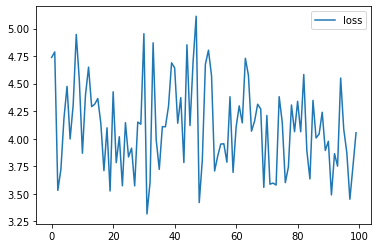

4.1158391461514015

In [42]:
train_loader = data_loader(train_dataset, batch_size=BATCH_SIZE)

train(model, train_loader, optimizerW, steps=100)

In [43]:
def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):                         
            next_logp = model.forward(batch["input_ids"].to(device), batch["length"])   # BatchSize X InLen X VocSize
            pred_logp_next_tokens = next_logp[:, :-1].contiguous().view(-1, INPUT_DIM)  # (BatchSize * InLen) X VocSize 
            actual_next_tokens = batch["input_ids"][:, 1:].contiguous().view(-1)        # (BatchSize * InLen)

            loss = F.nll_loss(input=pred_logp_next_tokens.to(device), 
                            target=actual_next_tokens.to(device))                       # scalar

            epoch_loss += loss.detach().cpu().tolist()
        
    return epoch_loss / len(iterator)                                                   # средняя на батч

In [44]:
train_loader = data_loader(train_dataset, BATCH_SIZE)
val_loader = data_loader(val_dataset, BATCH_SIZE, shuffle=False)

train_history = []
valid_history = []

best_valid_loss = float('inf')

if not SKIP:
    for epoch in range(N_EPOCHS):
        
        start_time = time.time()
        
        train_loss = train(model, train_loader, optimizerW, draw=False)
        valid_loss = evaluate(model, val_loader)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_NAME)
            
            
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    plt.plot(list(range(N_EPOCHS)), train_history, label='train loss')
    plt.legend()
    plt.show()

In [45]:
model.load_state_dict(torch.load(MODEL_NAME, map_location=device))

test_loader = data_loader(test_dataset, BATCH_SIZE, shuffle=False)

test_loss = evaluate(model, test_loader)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.264 | Test PPL:  71.065 |


# Генерация заголовков
- жадная генерация - не вариант

In [46]:
import numpy as np 

def generate(model, tokenizer, abstract, length=100):
    model.eval()   # перевести в режим прогноза
    
    # к стартовой последовательности добавляется токен конца аннотации
    x_sequence = tokenizer.encode([abstract])["input_ids"][:-1] + [tokenizer.tokenizer.subword_to_id(tokenizer.eoa)]
    seq_len = len(x_sequence)
    x_sequence = torch.LongTensor([x_sequence]).to(device)               
    
    answer = []
    for _ in range(length):
        logp_next = model.forward(x_sequence, src_len=[seq_len]).detach().cpu()
        p_next = F.softmax(logp_next, dim=-1).data.numpy()[0, -1]
        
        next_ix = np.argmax(np.array(p_next))       
        answer.append(next_ix)
        
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1).to(device)
    
    return tokenizer.decode([answer])[0]

In [47]:
N = 3
idx = np.random.choice(len(all_train_dataset.data), N)
abstracts, titles = np.array(all_train_dataset.data.abstract)[idx], np.array(all_train_dataset.data.title)[idx]

for abstract, title in zip(abstracts, titles):
    print(f"Reference:\t{title}\nCandidate:\t{generate(model, bpe, abstract)}\n", end="\n"+"-"*100 + "\n")

Reference:	logarithmic components of the vacant set for random walk on a discrete   torus
Candidate:	

----------------------------------------------------------------------------------------------------
Reference:	global regularity of wave maps iv. absence of stationary or self-similar   solutions in the energy class
Candidate:	

----------------------------------------------------------------------------------------------------
Reference:	moment estimators of the extreme value index for randomly censored data   in the weibull domain of attraction
Candidate:	

----------------------------------------------------------------------------------------------------


- лучевой поиск

In [48]:
from helpers.poetry import BeamGenerator

beam_generate = BeamGenerator(model, bpe)

def gen(seed_text, beamsize=5, return_hypotheses_n=1):
    score, source_candidate = beam_generate(seed_text, beamsize=beamsize, return_hypotheses_n=return_hypotheses_n)[0]
    candidate = source_candidate.split("<eoa>")[-1]
    return score, candidate

N = 5
idx = np.random.choice(len(all_train_dataset.data), N)
abstracts, titles = np.array(all_train_dataset.data.abstract)[idx], np.array(all_train_dataset.data.title)[idx]

for abstract, title in zip(abstracts, titles):
    score, candidate = gen(abstract)
    print(f"Reference:\t{title}\nCandidate:\t{candidate}\n{score=:.2f}", end="\n"+"-"*100 + "\n")

Reference:	clades and clans: a comparison study of two evolutionary models
Candidate:	the yule-harding-kingman (yhk) model and the proportional to distinguishable arrangements (pda) model are two binary tree generating models that are widely used in evolutionary biology. understanding the distributions of clade sizes under these two models provides valuable insights into macro-evolutionary processes, and is important in hypothesis testing and bayesian analyses in phylogenetics. here we show that these distributions are log-convex, which implies that very large clades or very small clades are more likely to occur under these two models. moreover, we prove that there exists a critical value $\kappa(n)$ for each $n\geqslant 4$ such that for a given clade with size $k$, the probability that this clade is contained in a random tree with $n$ leaves generated under the yhk model is higher than that under the pda model if $1<k<\kappa(n)$, and lower if $\kappa(n)<k<n$. finally, we extend our re

С такой генерацией дальше нет смылса считать.
- общая тематика улавливается (улавливалась, но модель не сохранилась), но конкретно референсные заголовки не выходят

# BLEU-score

- слабый baseline: 0.28204

In [49]:
# n_gram_weights = [0.3334, 0.3333, 0.3333]


# sources, targets = all_train_dataset.data.abstract, all_train_dataset.data.title    # pd.Series

# macro_bleu = 0
# for i, src in enumerate(tqdm(sources)):
#     candidate = generate(model, bpe, src).split()
#     reference = targets.loc[i].split()
#     macro_bleu += bleu_score([candidate], [reference], max_n=3, weights=n_gram_weights)

# macro_bleu /= len(sources)

# print(f'Macro-average BLEU (LSTM): {macro_bleu}')

# submission в Kaggle

Генерация заголовков для тестовых данных:

In [50]:
# SUBMISSION_NAME = "my2"

# titles = []
# for abstract in tqdm(fin_test_src):
#     title = generate(model, bpe, abstract).split()
#     title = title if title else "na"
#     titles.append(title)

Записываем полученные заголовки в файл формата `<abstract>,<title>`:

In [51]:
# submission_df = pd.DataFrame({'abstract': fin_test_src, 'title': titles})

# submission_df.to_csv(f"./submission/{SUBMISSION_NAME}_submission/predicted_titles.csv", index=False)

С помощью скрипта `generate_csv` приводим файл `submission_prediction.csv` в формат, необходимый для посылки в соревнование на Kaggle:

In [52]:
# from helpers.create_submission import generate_csv

# generate_csv(input_file=f'./submission/{SUBMISSION_NAME}_submission/predicted_titles.csv', 
#              output_file=f'./submission/{SUBMISSION_NAME}_submission/submission.csv', 
#              voc_file=f'./datasets/vocs.pkl')